 Гафни Даниил, 306 группа, физический факультет МГУ

## Постановка задачи

Используя схему бегущего счета и итерационные методы, решить задачу для квазилинейного уравнением переноса:

$$\left\{\begin{aligned}
\frac{\partial u}{\partial t} + \frac{2+\cos u}{1 + (2u + 1 + \sin u)^2} \frac{\partial u}{\partial x} = 0, \ ~ 0 < x \leq 1, \\
u(x,0) = \cos \frac{\pi x}{2}, \\
u(0,t) = 1 + \frac{1}{2} \arctan t.
\end{aligned}\\
\right. $$



## Исследование характеристик

В точках пересечения проекций его характеристик, решение будет разрывным. Посмотрим как будут вести себя проекции характеристик в заданных областях. Уравнение характеристик будет иметь вид 
$~~dt=\frac{1 + (2u + 1 + \sin u)^2}{2+\cos u}dx$

Преобразуем его.

$\int_{t_o}^{t}dt=\int_{x_o}^{x} \frac{1 + (2u + 1 + \sin u)^2}{2+\cos u}dx $

$t=\frac{1 + (2u_0 + 1 + \sin u_0)^2}{2+\cos u_0}(x-x_0)+t_0$

Воспользуемся начальным и граничным условиями для получения двух семейств кривых:

1) $~~t_0=0: ~~~~~ t=\frac{1 + (2\cos \frac{\pi x_0}{2} + 1 + \sin (\cos \frac{\pi x_0}{2})^2)}{2+\cos (\cos \frac{\pi x_0}{2})}(x-x_0)$

2) $~~x_0=0: ~~~~~ t=\frac{1 + (3 + \arctan t_0 + \sin (1 + \frac{1}{2} \arctan t_0))^2}{2+\cos (1 + \frac{1}{2} \arctan t_0)}x+t_0$

Необходимо будет построить соответсвующие графики и проверить их на отсутствие пересечений кривых.

Для удобства введем обозначение:

$C(u) = \frac{2+\cos u}{1 + (2u + 1 + \sin u)^2}$

## Численное решение

### Сетка

Введем в области $\Omega=\{(x,t):0\leq x<4,~~0<t<4\} $ сетку с шагом $h_x$ по $x$ и шагом $h_t$ по $t$:
\begin{eqnarray}
\omega_{h_x, ~ h_t}=\begin{cases}
x_n=n\cdot h_x, ~~h_x=\frac{1}{N}, ~~n=\overline{0, N}\\
t_m=m\cdot h_t, ~~h_t=\frac{1}{M}, ~~m=\overline{0, M}
\end{cases}
\end{eqnarray}

На $\omega_{h_x, ~ h_t}$ будем рассматривать сеточную функцию $y^m_{n}=u(x_n,t_m)$

## Шаблон


Перепишем исходное уравнение, приведя его к дивергентному виду: 

$$\frac{\partial u}{\partial t} + \frac{\partial (\arctan (2u + \sin u +1))}{\partial x} = 0 $$

Для удобства введем обозначение:

$C\_i(u) = \arctan (2u + \sin u +1)$ - первообразная функции $C(u)$

Для рассматриваемой задачи будем использовать [четырехточечный шаблон](http://math.phys.msu.ru/data/374/tema5.pdf). Он безусловно устойчив и аппроксимирует задачу как $ O({h_x}^2 + {h_t}^2)$.

Таким образом, разностная схема задачи имеет вид:

$$\frac{y^{m+1}_n - y^m_{n} + y^{m+1}_{n+1} - y^m_{n+1}}{2h_t} - \frac{C\_i(y^{m+1}_{n}) - C\_i(y^{m}_{n}) + C\_i(y^{m+1}_{n+1}) - C\_i(y^{m}_{n+1})}{2h_x}=0$$

Также начальное и граничное условия:

$$\left\{\begin{aligned} 
y^0_n= \cos \frac{\pi n h_x}{2}\\
y^{m}_0 = 1 + \frac{1}{2} \arctan(m h_t)
\end{aligned}\\
\right. $$


## Код

### Импортируем необходимые библиотеки

In [1]:
import numpy as np

import plotly
import plotly.graph_objs as go

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

import warnings

from IPython.display import clear_output, HTML, display

### Проведем необходимые настройки

In [2]:
plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Создадим класс TransportEquationSolver

In [3]:
class TransportEquationSolver:
    '''Класс для численного решения уравнения переноса.
    '''
    state_functions = False
    
    def __init__(self, X_START=0, X_END=1, T_START=0, T_END=1,
                 N=1000, M=1000, error=0.00001):
        
        # Задание параметров сетки
        self.X_START = X_START
        self.X_END = X_END
        self.T_START = T_START
        self.T_END = T_END
        self.N = N
        self.M = self.N  # На данный момент это сделано, 
        #потому что иначе будет выводиться неполный график (будет исправлено)
        
        # Задание параметров метода Ньютона
        self.error = error
        self.i_max = 10000
        
        # Создание сетки и шагов по x и t
        self.x = np.linspace(X_START, X_END, N)
        self.t = np.linspace(T_START, T_END, M)
        self.dx = self.x[1] - self.x[0]
        self.dt = self.t[1] - self.t[0]
            
    def initialize(self, C, C_integral , condition_initial, condition_border,
                   heterogeneity, heterogeneity_div):
        '''Метод инициализации данных. Принимает на вход функцию C, ее производную, а так же
        начальное и граничное условия, неоднородность и производную неоднородности.
        '''
        
        # Определение функций
        self.C = C
        self.C_integral = C_integral
        self.condition_initial = condition_initial
        self.condition_border = condition_border
        self.heterogeneity = heterogeneity
        self.heterogeneity_div = heterogeneity_div
        
        # Создание матрицы u и заполнение соответствующих строки и столбца начальным и граничным условиями
        self.u = np.empty((self.N, self.M))
        
        self.u[0] = condition_border(self.t)
        
        self.u = self.u.T        
        self.u[0] = condition_initial(self.x)
        self.u = self.u.T        
            
        # Значения функции u(x, t) в точка, на которых в данный момент будет выполняться шаблон
        self.__u11 = self.u[0][0]
        self.__u12 = self.u[0][1]
        self.__u21 = self.u[1][0]
        
    def calculate_u(self):
        '''Главный метод класса. Вычисляет значения u(x, t) на всей сетке.
        '''
        
        print('Calculating...')
        for n in range(1, self.N):
            clear_output(wait = True)
            print(f'Progress: {round(n/(self.N-1)*100)}%')
            for m in range(1, self.M):
                
                # Определение точек, на которых будет работать шаблон
                self.__u11 = self.u[n-1][m-1]
                self.__u21 = self.u[n][m-1]
                self.__u12 = self.u[n-1][m]
                
                # Вычисление значения u в новой точке
                u_new = self.solve_newton(self.template, self.template_div, self.__u11, self.i_max)
                self.u[n][m] = u_new
        print('Done!')
        
    def template(self, u22):
        '''Четырехточечный шаблон.
        '''
        
        return 0.5*(self.__u12 - self.__u11 + u22 -self.__u21) / self.dt + 0.5*(self.C_integral(u22) -
                                                                                 self.C_integral(self.__u12) + 
                                                                                 self.C_integral(self.__u21) - 
                                                                                 self.C_integral(self.__u11)) / self.dx
                
    def template_div(self, u22):
        '''Производная четырехточечного шаблона.
        '''
        
        return 0.5 / self.dt + 0.5*(self.C(u22)) / self.dx 
        
    def solve_newton(self, f, f_div, x0, i_max):
        '''Численное вычисление корня функции при помощи метода Ньютона.
        Принимает на вход функцию, ее производную,
        начальное приближение и максимальное число итераций.
        '''
        
        x = x0
        i = 0
        while abs(f(x)) > self.error and i < i_max:
            x += (-f(x) / f_div(x))
            i+=1
        return x
    
    
    def characteristics(self, x, x0=0, t0=0, first=True):
        '''Метод, который позволяет получить функции характеристик
        first = True - t0 = 0
        first = False - x0 = 0
        '''
        
        if first:
            t0 = 0
            return 1/self.C(self.condition_initial(x0))*(x - x0)
        if not first:
            x0 = 0
            return 1/self.C(self.condition_border(t0))*x + t0
    
    def plot_characteristics(self, x_start, x_end, t_start, t_end, how_many):
        '''Метод, который строит график характеристик. 
        Принимает на вход четыре числа - границы по x и t,
        внутри которых будут построены характеристики,
        а так же число кривых для построения.
        '''
        
        f, axs = plt.subplots(2,2,figsize=(14,7))
        f.suptitle('Characteristics plot')
        plt.subplot(1, 2, 1)
        plt.xlim(self.X_START, self.X_END)
        plt.ylim(t_start, t_end)
        plt.title('First family')
        plt.xlabel('x')
        plt.ylabel('t')
        x_for_char = np.linspace(x_start, x_end, how_many)
        t_for_char = np.linspace(t_start, t_end, how_many)
        for x0 in x_for_char:
            plt.plot(self.x, self.characteristics(self.x, x0 = x0))
        plt.subplot(1, 2, 2)
        plt.title('Second family')
        plt.xlim(self.X_START, self.X_END)
        plt.ylim(t_start, t_end)
        plt.xlabel('x')
        plt.ylabel('t')
        for t0 in t_for_char:
            plt.plot(self.x, self.characteristics(self.x, t0 = t0, first = False))
        
    def plot_conditions(self):
        '''Метод, который строит график начального и граничного условий.
        '''
        
        f, axs = plt.subplots(2,2,figsize=(14,7))
        f.suptitle('Conditions plot', )
        plt.subplot(1, 2, 1)
        plt.title('Initial Condition')
        plt.xlabel('x')
        plt.ylabel('u')
        plt.plot(self.x, self.u.T[0][:])
        plt.subplot(1, 2, 2)
        plt.title('Border Condition')
        plt.xlabel('t')
        plt.ylabel('u')
        plt.plot(self.t, self.u[:][0])
        
    def show_evolution_visualisation(self, filename = 'basic_animation.mp4'):
        '''Метод, который отображает визуализацию эволюции u(x, t),
        а так же записывает ее в .mp4 видеофайл.
        '''
        
        fig = plt.figure(dpi = 200)
        ax = plt.axes(xlim=(self.X_START, self.X_END),
                      ylim=(np.min(self.u), np.max(self.u)))
        line, = ax.plot([], [], lw=2)

        textvar = fig.text(0.15, 0.15, '', fontsize = 20)

        def init():
            line.set_data([], [])
            return line,

        def animate(i):
            x = self.x
            y = self.u.T[i]
            plt.xlabel('x')
            plt.ylabel('u(x, t)')
            textvar.set_text(f't = {round(self.t[i], 1)}')
            line.set_data(x, y)
            return line,

        anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(self.t), interval=10000/(len(self.t)), blit=True)

        anim.save(filename, fps=30, extra_args=['-vcodec', 'libx264'])
        
        plt.close(fig)
        
        return anim

### Определим функции конкретной задачи

In [4]:
def C(u):
    return (2 + np.cos(u)) / (1 + 2*u + 1 + np.sin(u))**2

def C_integral(u):
    return np.arctan(2*u + np.sin(u) + 1)

def condition_initial(x):
    return np.cos(np.pi*x/2)

def condition_border(t):
    return 1 + 0.5*np.arctan(t)

def heterogeneity(u):
    return 0

def  heterogeneity_div(u):
    return 0

### Создадим объект класса TransportEquationSolver, инициализируем нашу задачу.


In [5]:
solver_for_chars = TransportEquationSolver(N = 100, M = 100)
solver_for_chars.initialize(C, C_integral, condition_initial, condition_border, 
                            heterogeneity,  heterogeneity_div)

### Построение характеристик

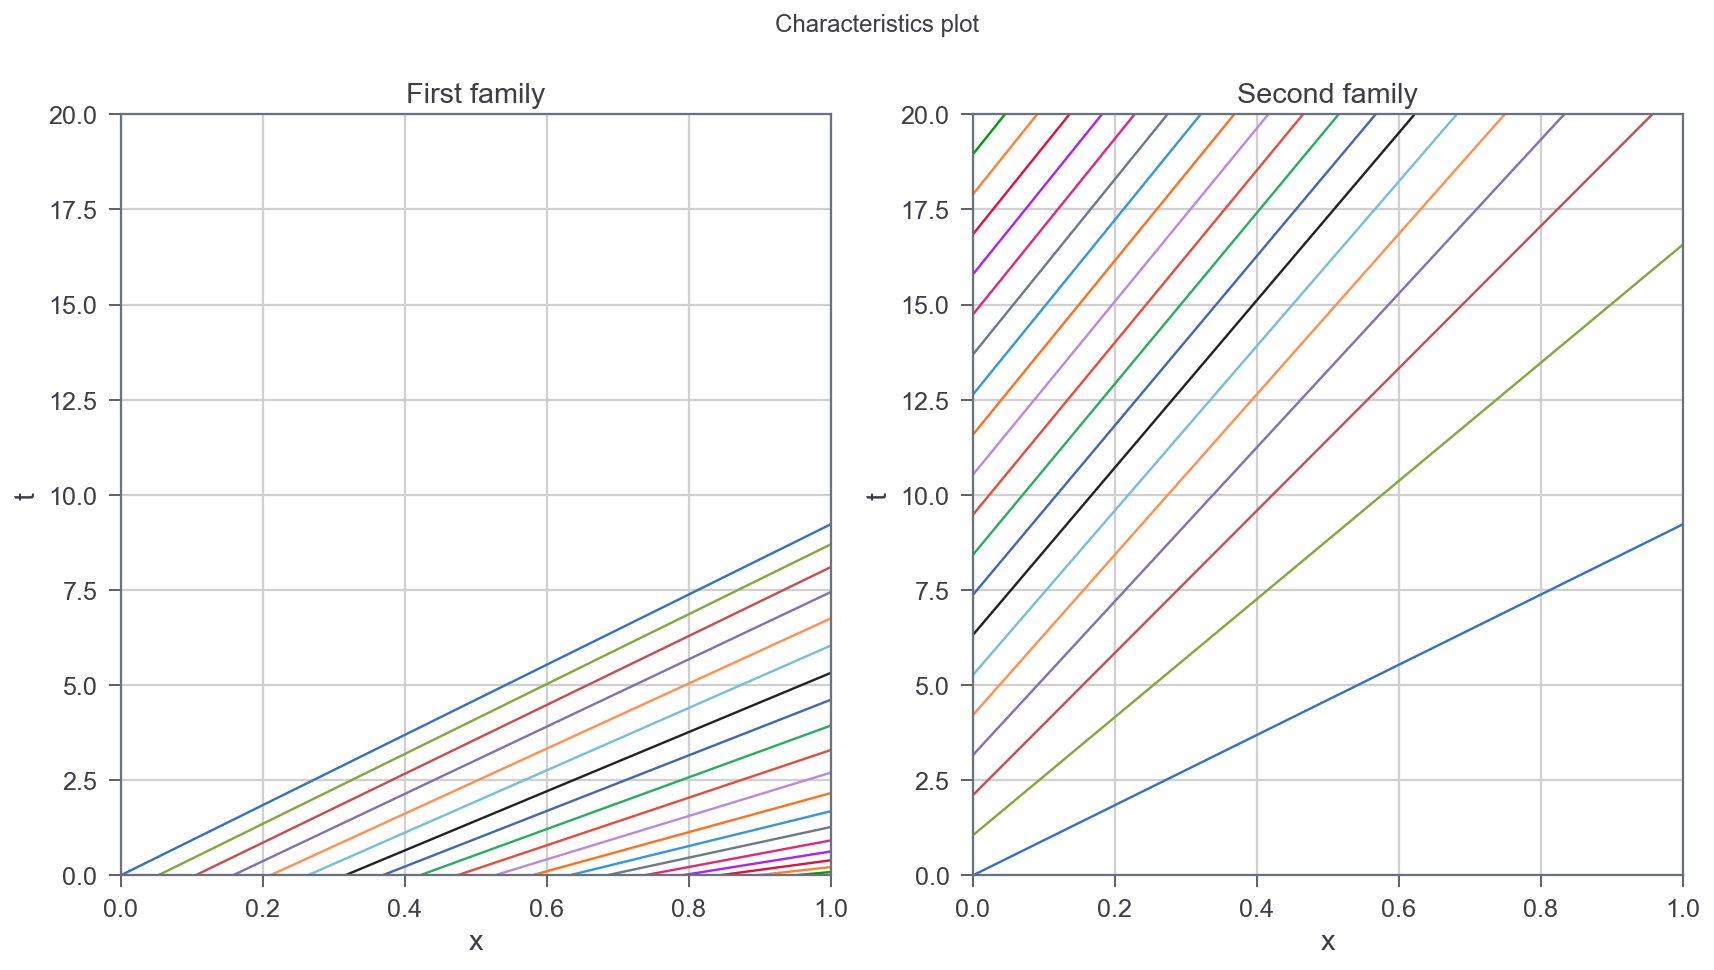

In [6]:
solver_for_chars.plot_characteristics(0, 1, 0, 20, 20)

Как видно, в заданных областях пересечений нет. 

Следовательно, нет так называемого опрокидывания волны, и во всей области решение будет представимо через разностную схему.

Возьмем 20 за вернюю границу t и создадим объект класса TransportEquationSolver с нужными нам параметрами.

In [7]:
solver = TransportEquationSolver(T_END = 20, N = 1000, M = 1000)
solver.initialize(C, C_integral, condition_initial, condition_border,
                  heterogeneity,  heterogeneity_div)

### Построим график начального и граничных условий.

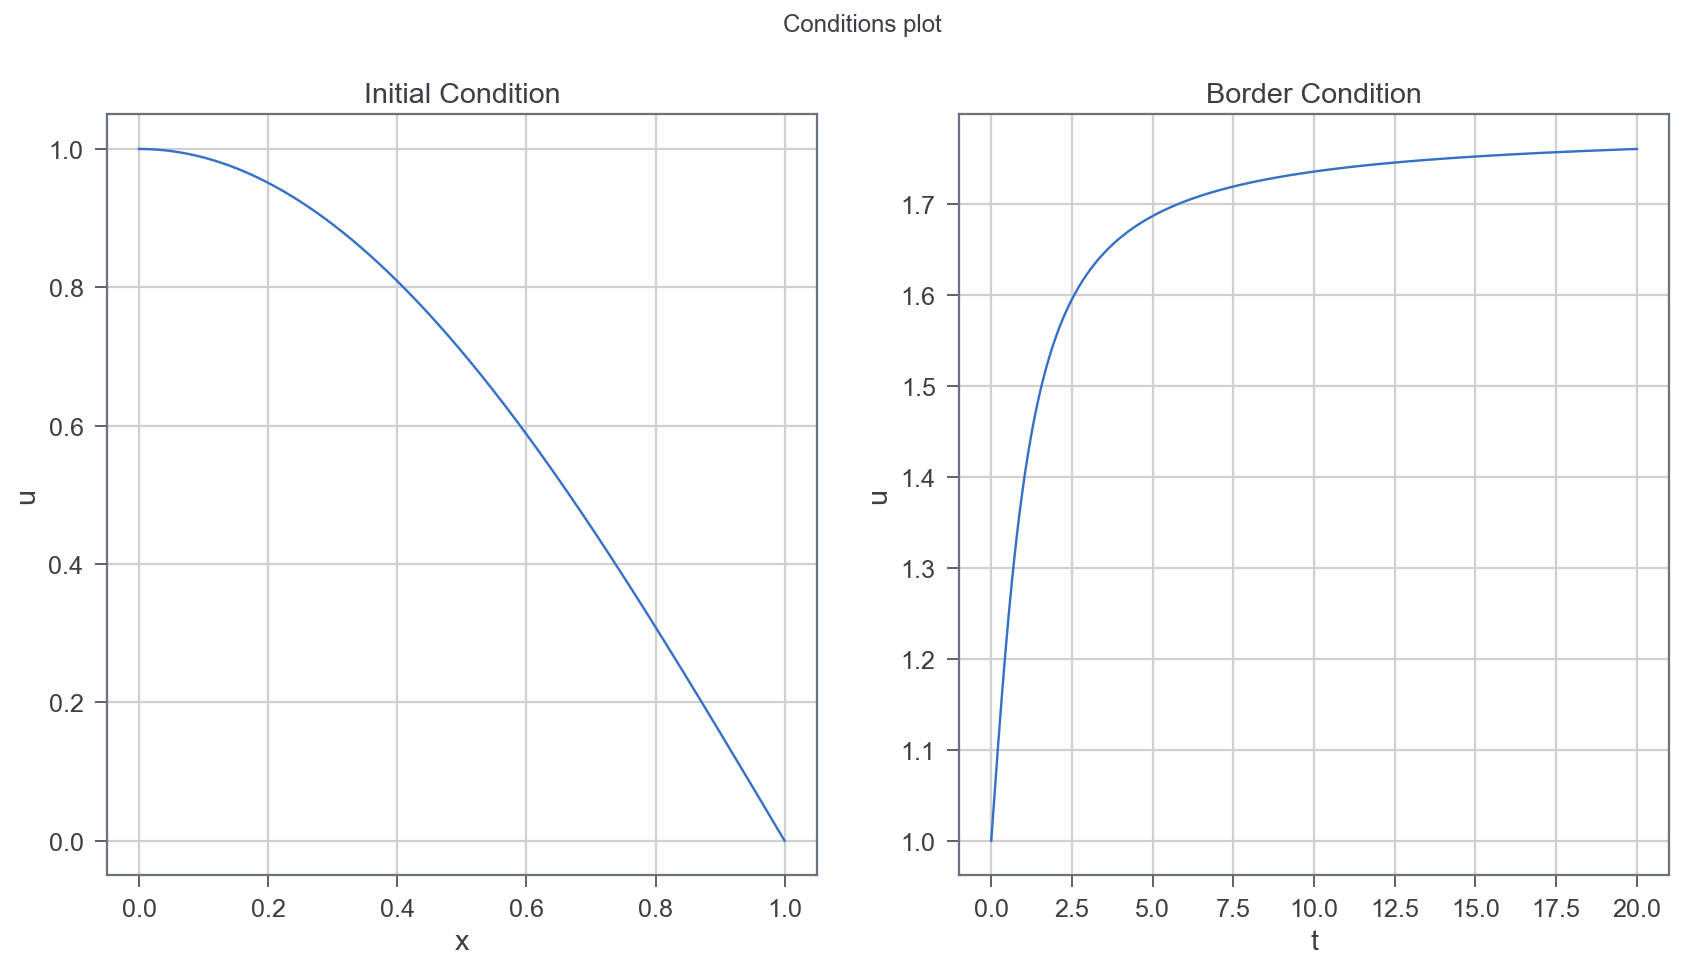

In [ ]:
solver.plot_conditions()

### Вычислим значение функции u(x, t) во всех точках сетки.

In [ ]:
solver.calculate_u()

Progress: 32%


### График численного решения задачи

In [ ]:
x, t, u = solver.x, solver.t, solver.u
data = [go.Surface(x = x, y = t, z = u.T)]
layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        title='x',
                        gridcolor="rgb(255, 255, 255)",
                        zerolinecolor="rgb(255, 255, 255)",
                        showbackground=True,
                        backgroundcolor="rgb(200, 200, 230)"),
                        
                    yaxis = dict(
                        title='t',
                        gridcolor="rgb(255, 255, 255)",
                        zerolinecolor="rgb(255, 255, 255)",
                        showbackground=True,
                        backgroundcolor="rgb(230, 200,230)"),
                        
                    zaxis = dict(
                        title='u(x, t)',
                        gridcolor="rgb(255, 255, 255)",
                        zerolinecolor="rgb(255, 255, 255)",
                        showbackground=True,
                        backgroundcolor="rgb(230, 230,200)",),),
                    width=800, height=600, 
                    margin=dict(
                    r=20, b=10,
                    l=10, t=10)
                  )

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'OMM_Task_1')

### "Карта высот" численного решения

In [ ]:
plt.figure(figsize = (10, 10))
plt.imshow(u)

### Видео-визуализация численного решения

In [ ]:
anim = solver.show_evolution_visualisation()
HTML(anim.to_jshtml())
plt.close()  # <-- Это нужно, чтобы обойти глупый баг, 
             #     который строит ненужный график после первого запуска
HTML(anim.to_jshtml())